# Tip-of-the-Tongue: Doodle-based Image Search

__Group 1:__ 
- New Jun Jie (A0196612B)
- Ai Bo (A0194528)
- Rishabh Anand (A0220603Y)

---

## 1. Introduction

__Tip of the tongue__ refers to the situation when we have a vague idea of an object in our memory but simply cannot name it. Most often than not, we feel that retrieval of the object's name is imminent. However, we can definitely draw out a doodle of this object when asked to. To do this, we seek to investigate the design of neural network architectures and the learning algorithms to learn such models. 

We firstly identify that the retrieval should be feature-based. This means we need to find a representation for each image with which we can quantitatively measure the similarity between a pair of images, i.e., manually-drawn doodle and potentially corresponding real-world photos. After learning a model that takes in images and produces meaningful representations of the inputs, we construct an engine that takes a drawn doodle as input, extracts the representation, compute similarity between the input and the images in the database, and finally output the top-k most similar images. Our project covers every aspect of the above pipeline, ranging from data collection to building such a retrieval engine that really works with real-world data.

In summary, our efforts are as follows: \
(0) We identified the problem of retrieving real-world photos by querying using doodles. \
(1) We collected (scraped) a dataset of 6k doodles and real-world images, and aggregated it with multiple existing datasets to a resulting combined size of > 100k samples.  \
(2) We performed data exploration, i.e., inspection of the statistics and visualization of the dataset real photos and doodles. \
(3) We cleaned up the dataset by removing duplicates and balancing the number of samples across classes. \
(4) We formulated our task as representation learning and propose to use the supervised contrastive learning to learn image representations. We also investigate the effects of model architectures and incorporate the design of the latest ConvNeXT into our CNN. \
(5) We implement the training loop and present the training statistics, along with a greedy hyperparameter tuner, as well as a comparative experiment results to show the superiority of our approach. \
(6) We implement the search engine that performs the actual image retrieval and provide a working demo. This makes our project not just a machine learning experiment, but a potential real-world application. \
(7) We present our project in this notebook and the presentation video. 

<b>The points 1-6 and 7 above correspond to the 8 steps in our grading rubrics. Moreover, we took the initiative to explore the state-of-the-art approaches for model construction and representation learning (point 4), and we close the loop of machine learning and the image retrieval application with our search engine (point 8). We believe the technical completeness and the engineering efforts of our project makes it a strong submission for the course project. </b>

As a taster, here are some interesting results:
<!-- ADD RESULTS w-->

## 2. Methodology
### 2.1 Problem formulation

![image](https://user-images.githubusercontent.com/27071473/159839313-d89281d8-0eb5-4b64-a308-7f7e7f7a0d87.png)

We aim to build an image vector search engine. The engine consists of a database of $N$ real-life images $D = \{r_i\}_{i=1}^N$ and a query function that takes in a doodle sketch $d$ and returns the top $k$ real-life images $R = \{r_i\}_{i=1}^k$ that are most relevant or similar to $d$, $R \subseteq D$. 

Specifically, we design the search engine as a system that computes the feature representation $f$ of the input doodle $d$ with a neural network model $h_1$, i.e., $f = h_1(d)$, and compute the cosine similarity between $f$ and the features of the real world images in the internal image base $\{f_i\}_{i=1}^N$, where $f_i = h_2(r_i), r_i \in D$. Next, the engine returns the top-k similiar images $K$

$$ K = \max_{r_i \in D} \cos(h_1(d), h_2(r_i)) $$

We identified the following two underlying machine learning and computer vision questions: \
(1) <b>Architecture</b>: what neural network architectures are best suited for the feature extractors $h_1$ and $h_2$, e.g., MLP, CNN, ConvNeXt? \
(2) <b>Algorithm</b>: what learning algorithms can learn the most informative representations for the search task, e.g., supervised learning, or semi- or unsupervised-learning techniques?

### 2.2 Method 

To tackle the technical challenges, we propose the following: \
(1) Incorporate neural structure designs from the well-known ResNet-50 and the more recent ConvNeXT into our models \
(2) Formulate the learning problem as representation learning problem and adopt the state-of-the-art supervised contrastive loss to learn the representations

Apart from proposing solutions and examine them both quantitatively and qualitatively, we will implement a search engine that actually performs the image retrieval to close the learning and application loop. 

However, different from most conference papers that presents an overview of the method in this section, we adopt a incremental presentation approach -- we propose <b>four</b> methods of learning the models $h_1$ and $h_2$ and present our proposed improvements one at a time. This can present our designs with clarity, and acts as an ablation study in itself. 

Next, we will start with data collection, then present the experimental results on the five versions we have. 

## 4. Data Collection and Exploratory Data Analysis

### 4.1 Data Collection and Web Scraping

We collect images of doodles and real photos from Google search by scraping using [SerpApi](https://serpapi.com/). A total of 4005 doodles and 905 reals were collected. On Google search, we query a combination of the class and terms such as "doodle", "sketch", "drawing easy" and "doodle single", e.g. "airplane doodle", "cat sketch". A variety of other sources of doodles and reals are used to supplement the collected dataset, e.g. CIFAR, Sketchy, TUBerlin. We also tried generating synthetic doodles from real photos using a combination of functions from OpenCV, but to no avail. The problem of doodle-based image search is difficult because of the limited number of available data sources, and most datasets are specially curated for niche doodle applications.

### 4.2 Image Preprocessing

Many Google images are coloured, although we are strictly interested in doodles that are black-white, so we use OpenCV to convert RGB to grayscale. There are also cases of images where the background is black while the outlines are white, so we flip the image pixel values by minusing 255. Duplicates are also removed to prevent test set leakage. Because images are all of different sizes, we standardise image sizes to 64x64 for doodles and 64x64x3 for reals.

Image shape: (256, 256)
No. classes: 9
Classes: airplane, car, bird, cat, dog, frog, horse, ship, truck
Count per class:
- airplane: 433
- car: 459
- bird: 455
- cat: 456
- dog: 454
- frog: 391
- horse: 459
- ship: 462
- truck: 436
Dataset size: 4005


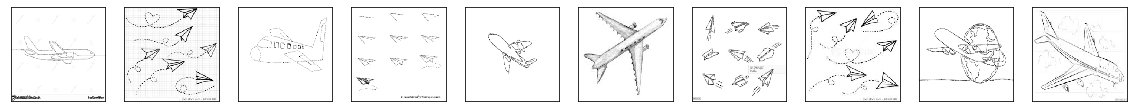

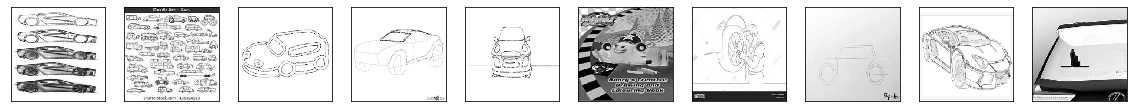

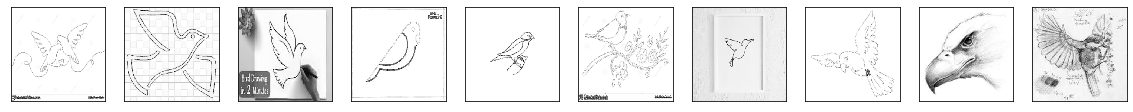

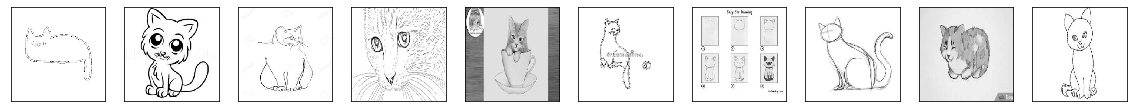

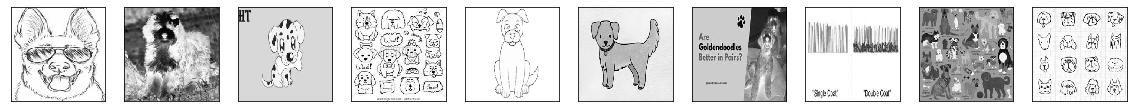

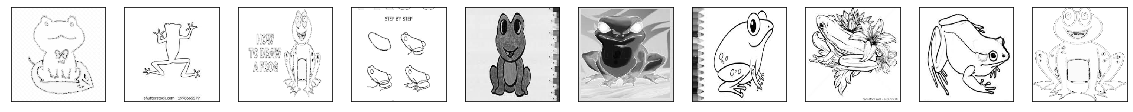

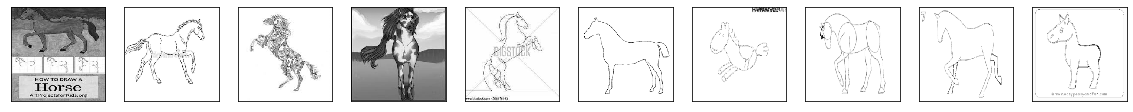

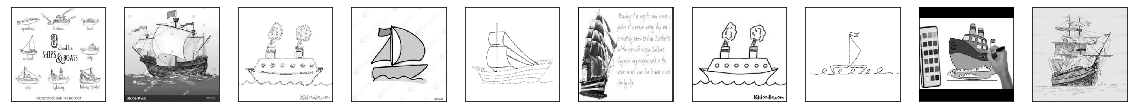

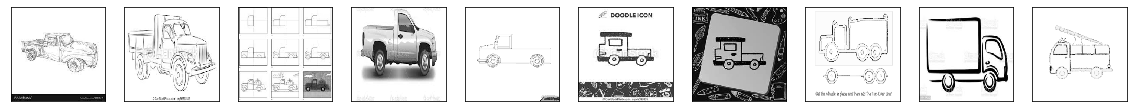

In [14]:
from dataset_collection import *

d = get_google_doodles()
print_dataset(d)
plot_dataset(d)

Image shape: (256, 256, 3)
No. classes: 9
Classes: airplane, car, bird, cat, dog, frog, horse, ship, truck
Count per class:
- airplane: 105
- car: 100
- bird: 100
- cat: 100
- dog: 100
- frog: 100
- horse: 100
- ship: 100
- truck: 100
Dataset size: 905


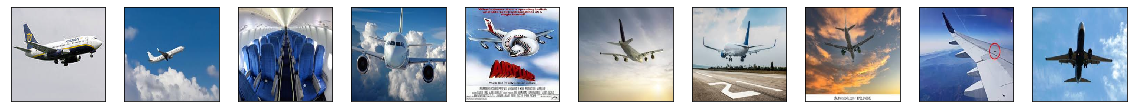

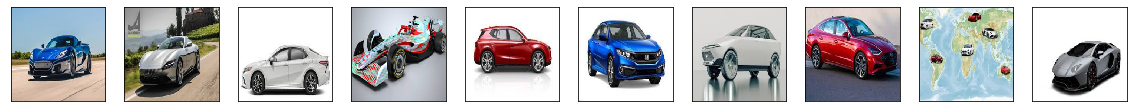

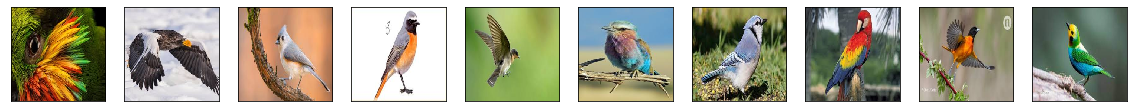

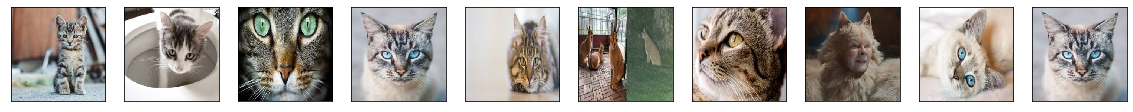

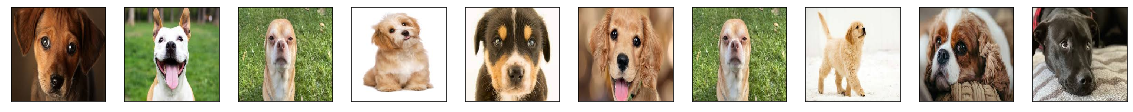

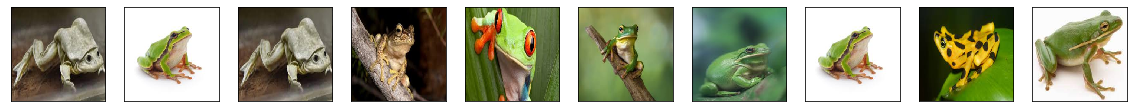

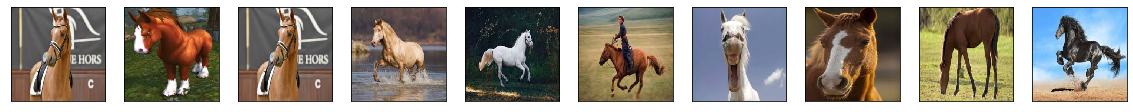

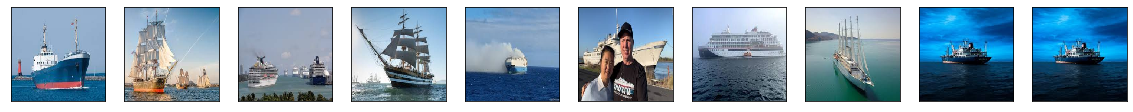

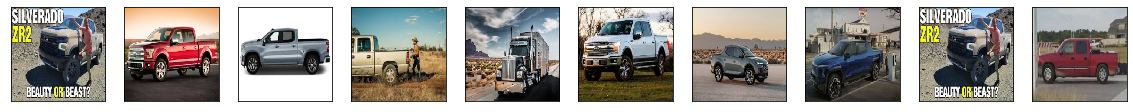

In [15]:
d = get_google_real()
print_dataset(d)
plot_dataset(d)

### 4.2 Dataset Statistics

The Google search datasets scraped (reals and doodles) do not face the problem of class imbalance .

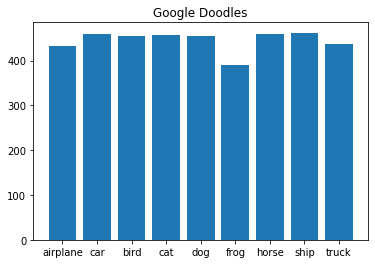

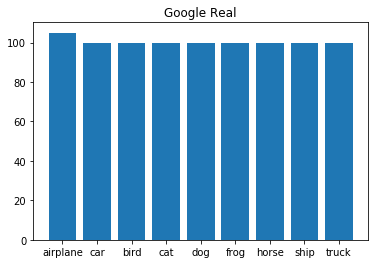

In [16]:
from dataset_analysis import *

d = get_google_doodles()
plot_dataset_dist(d, title="Google Doodles")

d = get_google_real()
plot_dataset_dist(d, title="Google Real")

In [17]:
d = collapse_datasets(get_doodle_datasets())
print_dataset(d)

d = collapse_datasets(get_real_datasets())
print_dataset(d)

Image shape: (64, 64)
No. classes: 9
Classes: airplane, bird, car, cat, dog, frog, horse, truck, ship
Count per class:
- airplane: 1041
- bird: 1039
- car: 1073
- cat: 1048
- dog: 1046
- frog: 973
- horse: 1064
- truck: 1040
- ship: 462
Dataset size: 8786
Image shape: (64, 64, 3)
No. classes: 9
Classes: airplane, car, bird, cat, dog, frog, horse, ship, truck
Count per class:
- airplane: 6205
- car: 6200
- bird: 6200
- cat: 6200
- dog: 6200
- frog: 6200
- horse: 6200
- ship: 6100
- truck: 6200
Dataset size: 55705


### 4.3 Dataset Visualization
To understand the general distribution of the datasets visually, we plot the pixel-wise mean of images in each dataset by class. We can see that for some classes of real, the background colour is obvious, e.g. blue for airplane because airplanes are likely in the sky, and green for bird because birds are likely spotted on grass or a tree. For doodles, commonly used outlines can be observed visually.

cifar


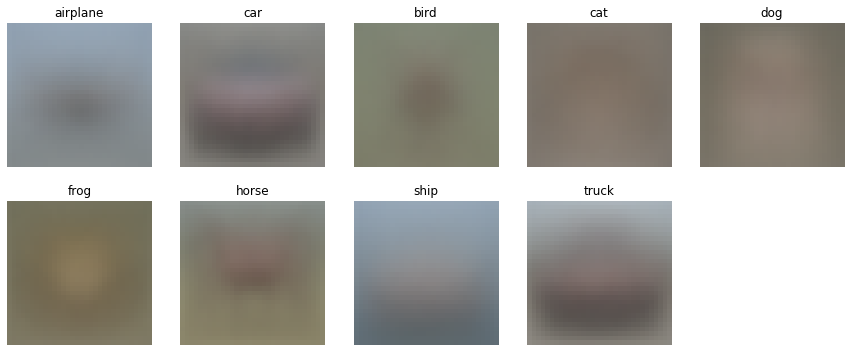

quickdraw


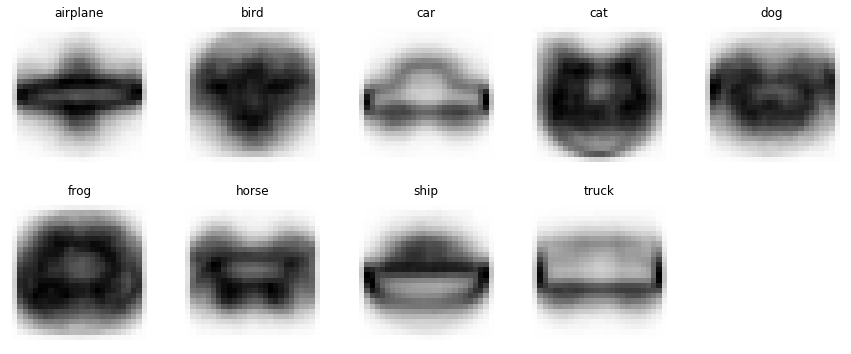

sketchy_real


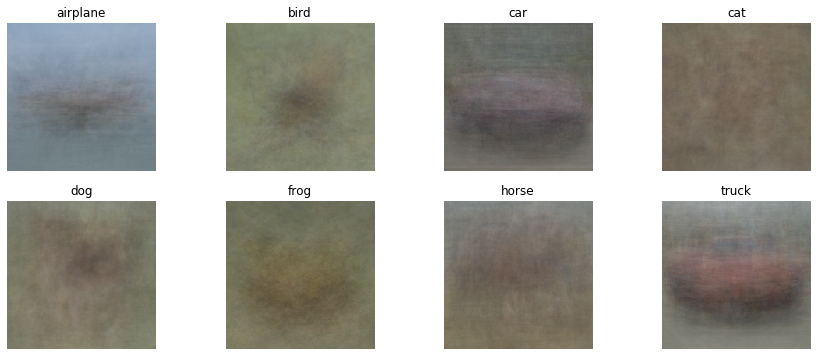

sketchy_doodle


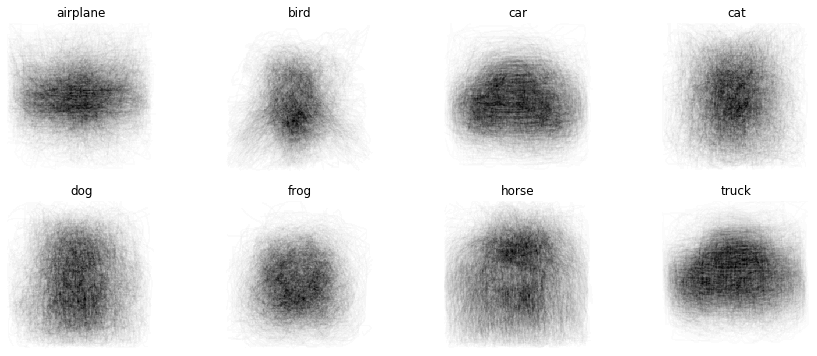

tuberlin


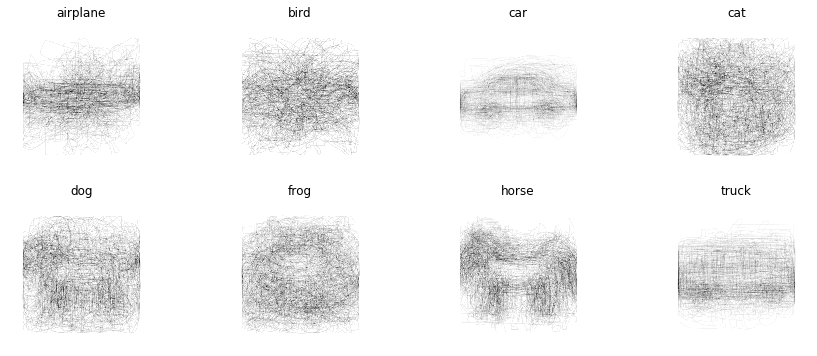

google_doodles


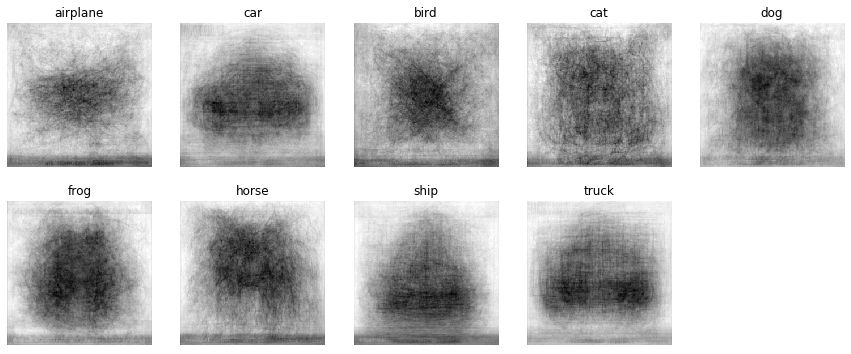

google_real


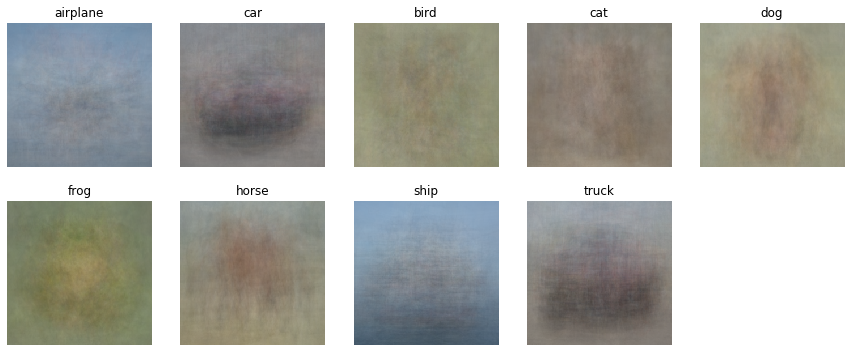

In [18]:
dd = get_all_datasets()
for name, d in dd.items():
    print(name)
    plot_dataset_mean(d)

## 5. Experiments

As aforementioned, we will progressive improve upon the baseline approach. Below is a summary of the four versions we will study.

(1) Version 1: Multilayer Perceptron Classification \
This is the simplest architecture and learning algorithm one can come up with.

(2) Version 2: Convolutional Neural Network Classification \
We improve the previous version by using a CNN. We consider architectural designs from ResNet and ConvNeXt<sup>1</sup>. Note that we implemented the models <b>from scratch</b>.

(3) Version 3: Convolutional Neural Network Classification with Contrastive Losses \
We explictly optimize pairwise relations between feature embeddings with contrastive training. 


---

<sup>1</sup> Liu, Z., Mao, H., Wu, C. Y., Feichtenhofer, C., Darrell, T., & Xie, S. (2022). A ConvNet for the 2020s. arXiv preprint arXiv:2201.03545.

## 5.1 Version 1: Multilayer Perceptron Classification

We first propose to use cross-entropy classification-based training to learn the representations. 

As a baseline, we use an MLP to parameterize the feature extractor. Below is the model architecture and the training process. 

```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
MLP                                      --                        --
├─LeakyReLU: 1-1                         --                        --
├─Dropout: 1-2                           --                        --
├─Sequential: 1-3                        --                        --
│    └─Linear: 2-1                       [128, 64]                 262,144
├─LeakyReLU: 1-4                         [128, 64]                 --
├─Dropout: 1-5                           [128, 64]                 --
├─Sequential: 1-3                        --                        --
│    └─Linear: 2-2                       [128, 9]                  576
==========================================================================================
Total params: 262,720
Trainable params: 262,720
Non-trainable params: 0
Total mult-adds (M): 33.63
==========================================================================================
Input size (MB): 2.10
Forward/backward pass size (MB): 0.07
Params size (MB): 1.05
Estimated Total Size (MB): 3.22
==========================================================================================
```

Note that we implememend a ```trainer``` class that wraps the training loop and exposes a simple interface for users. 

Epoch: 0 | Train Loss: 3.560 | Train Acc: 0.181 | Val Loss: 2.514 | Val Acc: 0.171
Epoch: 1 | Train Loss: 2.087 | Train Acc: 0.264 | Val Loss: 2.426 | Val Acc: 0.204
Epoch: 2 | Train Loss: 1.860 | Train Acc: 0.340 | Val Loss: 2.429 | Val Acc: 0.165
Epoch: 3 | Train Loss: 1.792 | Train Acc: 0.382 | Val Loss: 2.595 | Val Acc: 0.195
Epoch: 4 | Train Loss: 1.675 | Train Acc: 0.438 | Val Loss: 2.679 | Val Acc: 0.185
Epoch: 5 | Train Loss: 1.673 | Train Acc: 0.458 | Val Loss: 3.299 | Val Acc: 0.174
Epoch: 6 | Train Loss: 1.751 | Train Acc: 0.469 | Val Loss: 3.346 | Val Acc: 0.187
Epoch: 7 | Train Loss: 1.640 | Train Acc: 0.492 | Val Loss: 3.297 | Val Acc: 0.175
Epoch: 8 | Train Loss: 1.464 | Train Acc: 0.541 | Val Loss: 3.156 | Val Acc: 0.190
Epoch: 9 | Train Loss: 1.397 | Train Acc: 0.571 | Val Loss: 3.879 | Val Acc: 0.174
Epoch: 10 | Train Loss: 1.418 | Train Acc: 0.592 | Val Loss: 3.587 | Val Acc: 0.168
Epoch: 11 | Train Loss: 1.317 | Train Acc: 0.611 | Val Loss: 3.924 | Val Acc: 0.196
Ep

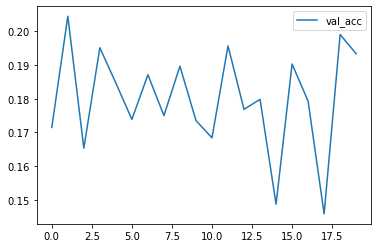

In [7]:
from model_training import *

trainset = DoodleDataset(train=True)
valset = DoodleDataset(train=False)

model = MLP(n_input=64*64, n_linear=2, dropout=0.2)

trainer = Trainer(model, trainset, valset, epochs=20, bs=128)
history = trainer.train(verbose=True)
trainer.plot()
trainer.save("mlp-doodle")

Epoch: 0 | Train Loss: 3.350 | Train Acc: 0.301 | Val Loss: 2.700 | Val Acc: 0.290
Epoch: 1 | Train Loss: 2.768 | Train Acc: 0.294 | Val Loss: 3.085 | Val Acc: 0.281
Epoch: 2 | Train Loss: 3.349 | Train Acc: 0.280 | Val Loss: 3.537 | Val Acc: 0.241
Epoch: 3 | Train Loss: 3.962 | Train Acc: 0.266 | Val Loss: 3.138 | Val Acc: 0.298
Epoch: 4 | Train Loss: 3.115 | Train Acc: 0.286 | Val Loss: 3.719 | Val Acc: 0.276
Epoch: 5 | Train Loss: 3.239 | Train Acc: 0.286 | Val Loss: 3.429 | Val Acc: 0.287
Epoch: 6 | Train Loss: 3.712 | Train Acc: 0.278 | Val Loss: 3.373 | Val Acc: 0.285
Epoch: 7 | Train Loss: 3.524 | Train Acc: 0.280 | Val Loss: 3.648 | Val Acc: 0.282
Epoch: 8 | Train Loss: 3.520 | Train Acc: 0.278 | Val Loss: 3.937 | Val Acc: 0.285
Epoch: 9 | Train Loss: 3.630 | Train Acc: 0.279 | Val Loss: 4.366 | Val Acc: 0.290
Epoch: 10 | Train Loss: 4.151 | Train Acc: 0.267 | Val Loss: 4.200 | Val Acc: 0.237
Epoch: 11 | Train Loss: 3.730 | Train Acc: 0.280 | Val Loss: 3.327 | Val Acc: 0.260
Ep

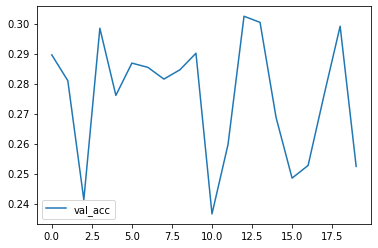

In [8]:
from model_training import *

trainset = RealDataset(train=True)
valset = RealDataset(train=False)

model = MLP(n_input=64*64*3, n_linear=2, dropout=0.2)

trainer = Trainer(model, trainset, valset, epochs=20, bs=128)
history = trainer.train(verbose=True)
trainer.plot()
trainer.save("mlp-real")

As can be seen from the statistics, the classification accuracy for the doodle and real-image datasets are 19.3% and 25.2%. 

## Section 5.2: Version 2: Convolutional Neural Network Classification

Next, we use a CNN to improve the model. The advantage of CNN is that it has translational invariance and has the locality assumption. The weight sharing should improve its robustness to overfitting. 


The final pipeline and architecture look like so:

```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
CNN                                      --                        --
├─Sequential: 1-1                        [128, 256, 1, 1]          --
│    └─Sequential: 2-1                   [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         640
│    │    └─BatchNorm2d: 3-2             [128, 64, 32, 32]         128
│    │    └─ReLU: 3-3                    [128, 64, 32, 32]         --
│    └─Sequential: 2-2                   [128, 64, 30, 30]         --
│    │    └─Conv2d: 3-4                  [128, 64, 30, 30]         36,928
│    │    └─BatchNorm2d: 3-5             [128, 64, 30, 30]         128
│    │    └─ReLU: 3-6                    [128, 64, 30, 30]         --
│    └─Sequential: 2-3                   [128, 128, 15, 15]        --
│    │    └─Conv2d: 3-7                  [128, 128, 15, 15]        73,856
│    │    └─BatchNorm2d: 3-8             [128, 128, 15, 15]        256
│    │    └─ReLU: 3-9                    [128, 128, 15, 15]        --
│    └─Sequential: 2-4                   [128, 128, 13, 13]        --
│    │    └─Conv2d: 3-10                 [128, 128, 13, 13]        147,584
│    │    └─BatchNorm2d: 3-11            [128, 128, 13, 13]        256
│    │    └─ReLU: 3-12                   [128, 128, 13, 13]        --
│    └─Sequential: 2-5                   [128, 192, 7, 7]          --
│    │    └─Conv2d: 3-13                 [128, 192, 7, 7]          221,376
│    │    └─BatchNorm2d: 3-14            [128, 192, 7, 7]          384
│    │    └─ReLU: 3-15                   [128, 192, 7, 7]          --
│    └─Sequential: 2-6                   [128, 192, 5, 5]          --
│    │    └─Conv2d: 3-16                 [128, 192, 5, 5]          331,968
│    │    └─BatchNorm2d: 3-17            [128, 192, 5, 5]          384
│    │    └─ReLU: 3-18                   [128, 192, 5, 5]          --
│    └─Sequential: 2-7                   [128, 256, 3, 3]          --
│    │    └─Conv2d: 3-19                 [128, 256, 3, 3]          442,624
│    │    └─BatchNorm2d: 3-20            [128, 256, 3, 3]          512
│    │    └─ReLU: 3-21                   [128, 256, 3, 3]          --
│    └─Sequential: 2-8                   [128, 256, 1, 1]          --
│    │    └─Conv2d: 3-22                 [128, 256, 1, 1]          590,080
│    │    └─BatchNorm2d: 3-23            [128, 256, 1, 1]          512
│    │    └─ReLU: 3-24                   [128, 256, 1, 1]          --
│    └─AdaptiveAvgPool2d: 2-9            [128, 256, 1, 1]          --
├─Dropout: 1-2                           [128, 256]                --
├─Linear: 1-3                            [128, 9]                  2,313
==========================================================================================
Total params: 1,849,929
Trainable params: 1,849,929
Non-trainable params: 0
Total mult-adds (G): 12.69
==========================================================================================
Input size (MB): 2.10
Forward/backward pass size (MB): 389.82
Params size (MB): 7.40
Estimated Total Size (MB): 399.31
==========================================================================================
```



A diagram for the architecture is shown below. 

<img src="image-20220429-214642.png" width="750" />

Epoch: 0 | Train Loss: 1.929 | Train Acc: 0.276 | Val Loss: 2.287 | Val Acc: 0.149
Epoch: 1 | Train Loss: 1.648 | Train Acc: 0.379 | Val Loss: 2.020 | Val Acc: 0.219
Epoch: 2 | Train Loss: 1.431 | Train Acc: 0.462 | Val Loss: 1.874 | Val Acc: 0.320
Epoch: 3 | Train Loss: 1.301 | Train Acc: 0.511 | Val Loss: 2.042 | Val Acc: 0.283
Epoch: 4 | Train Loss: 1.136 | Train Acc: 0.574 | Val Loss: 2.257 | Val Acc: 0.319
Epoch: 5 | Train Loss: 0.979 | Train Acc: 0.639 | Val Loss: 2.440 | Val Acc: 0.271
Epoch: 6 | Train Loss: 0.893 | Train Acc: 0.675 | Val Loss: 2.215 | Val Acc: 0.335
Epoch: 7 | Train Loss: 0.771 | Train Acc: 0.724 | Val Loss: 1.692 | Val Acc: 0.402
Epoch: 8 | Train Loss: 0.638 | Train Acc: 0.772 | Val Loss: 2.167 | Val Acc: 0.408
Epoch: 9 | Train Loss: 0.568 | Train Acc: 0.798 | Val Loss: 2.129 | Val Acc: 0.396
Epoch: 10 | Train Loss: 0.459 | Train Acc: 0.838 | Val Loss: 2.336 | Val Acc: 0.442
Epoch: 11 | Train Loss: 0.397 | Train Acc: 0.864 | Val Loss: 2.523 | Val Acc: 0.439
Ep

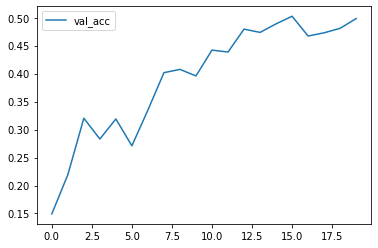

In [9]:
from model_training import *

trainset = DoodleDataset(train=True)
valset = DoodleDataset(train=False)

model = CNN(n_channels=1, dropout=0.2)

trainer = Trainer(model, trainset, valset, epochs=20, bs=128)
history = trainer.train(verbose=True)
trainer.plot()
trainer.save("cnn-doodle")

Epoch: 0 | Train Loss: 1.459 | Train Acc: 0.458 | Val Loss: 1.212 | Val Acc: 0.561
Epoch: 1 | Train Loss: 0.985 | Train Acc: 0.647 | Val Loss: 1.082 | Val Acc: 0.628
Epoch: 2 | Train Loss: 0.790 | Train Acc: 0.717 | Val Loss: 0.797 | Val Acc: 0.716
Epoch: 3 | Train Loss: 0.634 | Train Acc: 0.775 | Val Loss: 0.774 | Val Acc: 0.733
Epoch: 4 | Train Loss: 0.535 | Train Acc: 0.812 | Val Loss: 0.738 | Val Acc: 0.760
Epoch: 5 | Train Loss: 0.441 | Train Acc: 0.842 | Val Loss: 0.647 | Val Acc: 0.786
Epoch: 6 | Train Loss: 0.376 | Train Acc: 0.867 | Val Loss: 0.717 | Val Acc: 0.776
Epoch: 7 | Train Loss: 0.305 | Train Acc: 0.892 | Val Loss: 0.707 | Val Acc: 0.792
Epoch: 8 | Train Loss: 0.251 | Train Acc: 0.909 | Val Loss: 0.697 | Val Acc: 0.794
Epoch: 9 | Train Loss: 0.215 | Train Acc: 0.922 | Val Loss: 0.815 | Val Acc: 0.780
Epoch: 10 | Train Loss: 0.175 | Train Acc: 0.939 | Val Loss: 0.923 | Val Acc: 0.773
Epoch: 11 | Train Loss: 0.153 | Train Acc: 0.947 | Val Loss: 0.958 | Val Acc: 0.778
Ep

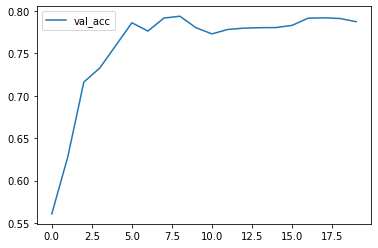

In [10]:
from model_training import *

trainset = RealDataset(train=True)
valset = RealDataset(train=False)

model = CNN(n_channels=3, dropout=0.2)

trainer = Trainer(model, trainset, valset, epochs=20, bs=128)
history = trainer.train(verbose=True)
trainer.plot()
trainer.save("cnn-real")

It can be seen that the CNN achieved 49.8% and 78.7% accuracy on the doodle and real-image dataset respectively. As expected, it outperforms the MLP by a significant margin. 

### 5.2.1 Hyperparameter Tuning for MLP/CNN

How did we choose our hyperparameters? 

We actually implemented a ```Tuner``` that automatically searches for the best hyperparameters via a greedy-based stategy. Because the number of hyperparameters can be large, a grid search of all combinations and permutations of hyperparameters easily results in $O(n^m)$ experiment runs, where $n$ is the number of values per hyperparameter and $m$ is the number of hyperparameters. Thus, grid search of hyperparameters is computationally infeasible.

The implemented greedy tuner iterates through the range of values for the first hyperparameter while taking all others constant, and then saves the hyperparameter value with the best validation performance. Then, the next hyperparameter range of values that is iterated over uses the previous best hyperparameter values. In theory, this loop can occur multiple times to obtain a somewhat decent approximation to exhaustive grid search.

After obtaining the best hyperparameters, we train the models like shown in the previous cells.

   dropout      *0.1       0.2       0.3       0.4       0.5
   val acc     0.204     0.177     0.197     0.179     0.175

  n_linear         1        *2         3
   val acc     0.183     0.207     0.207



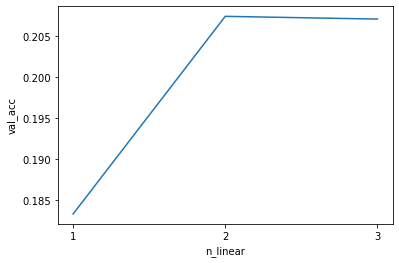

In [11]:
from hyperparameter_tuning import *

trainset = DoodleDataset(train=True)
valset = DoodleDataset(train=False)

param_ranges = {
    'dropout': [0.1, 0.2, 0.3, 0.4, 0.5],
    'n_linear': [1,2,3],
}
tuner = Tuner(MLP, trainset, valset, param_ranges, epoch=20)
tuner.tune()
tuner.plot('n_linear')

In [12]:
param_ranges = {
    'dropout': [0.1,0.2,0.3,0.4,0.5],
}
tuner = Tuner(CNN, trainset, valset, param_ranges, epoch=20)
tuner.tune()

   dropout       0.1      *0.2       0.3       0.4       0.5
   val acc     0.317     0.332     0.321     0.320     0.304



## 5.3 Version 3: Convolutional Neural Network with Contrastive Loss

However, cross-entropy training is not enough to learn meaningful representations for the retrieval task. This is because the key to accurate retrieval is <b>matching</b> between doodle representations and real image representations. To enforce the correspondences between different samples in the hidden space, we enfore such pairwise relations with a contrastive loss term.

The idea of contrastive loss is to pull closer the samples in a postive pair, but pull away the samples in a negative pair. Inspired by SimCLR<sup>2</sup>, we define our loss as follows:

$$
l(z) = -\log \frac{\sum_{a_i=a_j} \text{exp}(\text{sim}(z_i, z_j)/\tau)}{\sum_{k} \text{exp}(\text{sim}(z_i, z_k)/\tau)}
$$

where $z$ is a batch of features. The denominator is the pairwise similarity across all pairs in the batch, whereas the numerator is the sum of all positive pairs, defined as samples with the same label, i.e., $i$ and $j$ s.t. $a_i = a_j$ and $a$ is a label vector.

Based on this formulation, we actually have three losses that play different roles.

Loss 1 is applied to the real-image model. 
$$
l_1(z) = -\log \frac{\sum_{a_i=a_j} \text{exp}(\text{sim}(z_i, z_j)/\tau)}{\sum_{k} \text{exp}(\text{sim}(z_i, z_k)/\tau)}
$$
and 
$$
z = h_2(x_1)
$$
where $x_1$ is a batch of doodle images.

Loss 2 is applied to the doodle model.
$$
l_2(z) = -\log \frac{\sum_{a_i=a_j} \text{exp}(\text{sim}(z_i, z_j)/\tau)}{\sum_{k} \text{exp}(\text{sim}(z_i, z_k)/\tau)}
$$
and 
$$
z = h_1(x_2)
$$
where $x_2$ is a batch of real images.

Loss 3 is applied to <b>the element-wise product of the real-image representations $z_1$ and the doodle representations $z_2$ </b>.

$$
l_3(z) = -\log \frac{\sum_{a_i=a_j} \text{exp}(\text{sim}(z_i, z_j)/\tau)}{\sum_{k} \text{exp}(\text{sim}(z_i, z_k)/\tau)}
$$
where 
$$
z = z_1 * z_2
$$

Lastly, we add the three loss terms to the cross-entropy loss, which is the final loss term to be optimized
$$
l = l_1 + l_2 + l_3 + CE
$$

For a fair comparision, we use the same CNN architecture as Version 2.

---

#### References
<sup>2</sup> Chen, T., Kornblith, S., Norouzi, M., and Hinton, G. A simple framework for contrastive learning of visual representations. In International conference on machine learning, pp. 1597–1607. PMLR, 2020.

Here's a rough visualisation of __Loss 1__. Its main purpose is to bring together the real-life image embeddings from the same class and pull apart real-images from different classes.

![Picture title](image-20220429-220721.png)

Likewise, here's a rough visualisation of __Loss 2__. It works on doodle embeddings.

![Picture title](image-20220429-221026.png)

Finally, we combine the powers of Loss 1 and Loss 2 to bring together the doodle and real-life image embeddings from the same class while pulling apart the embeddings from different classes.

![Picture title](image-20220429-221720.png)

Below is the contrastive training process of our model. Again we use our ```Trainer```, and the loss function is built in the ```CNNCL``` model. 

Epoch: 0 | Train Loss: 9.188 | Train Acc: 0.383 | Val Loss: 8.674 | Val Acc: 0.384 | Doodle Acc: 0.264 | Real Acc: 0.505
Epoch: 1 | Train Loss: 5.822 | Train Acc: 0.633 | Val Loss: 7.997 | Val Acc: 0.505 | Doodle Acc: 0.367 | Real Acc: 0.643
Epoch: 2 | Train Loss: 3.743 | Train Acc: 0.782 | Val Loss: 8.390 | Val Acc: 0.542 | Doodle Acc: 0.420 | Real Acc: 0.664
Epoch: 3 | Train Loss: 2.330 | Train Acc: 0.867 | Val Loss: 8.896 | Val Acc: 0.586 | Doodle Acc: 0.458 | Real Acc: 0.714
Epoch: 4 | Train Loss: 1.713 | Train Acc: 0.903 | Val Loss: 9.814 | Val Acc: 0.613 | Doodle Acc: 0.480 | Real Acc: 0.747
Epoch: 5 | Train Loss: 1.388 | Train Acc: 0.923 | Val Loss: 10.228 | Val Acc: 0.610 | Doodle Acc: 0.467 | Real Acc: 0.754
Epoch: 6 | Train Loss: 1.181 | Train Acc: 0.938 | Val Loss: 10.441 | Val Acc: 0.617 | Doodle Acc: 0.451 | Real Acc: 0.782
Epoch: 7 | Train Loss: 1.083 | Train Acc: 0.947 | Val Loss: 10.585 | Val Acc: 0.616 | Doodle Acc: 0.452 | Real Acc: 0.780
Epoch: 8 | Train Loss: 0.820 

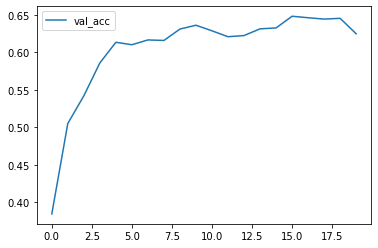

In [13]:
from model_training import *

trainset = ContrastiveDataset(train=True)
valset = ContrastiveDataset(train=False)

model = CNNCL(dropout=0.2, c1=1, c2=1, t=0.1)

trainer = Trainer(model, trainset, valset, epochs=20, bs=128)
history = trainer.train(verbose=True)
trainer.plot()
trainer.save("cnncl-contrastive")

From the cell output, the doodle accuracy and real-image accuracy are 47.1% and 77.9% respectively. Compared to the classification-based CNN model's 49.8% and 78.7%, our contrastive model has lower classification accuracy.

We argue this is because the model allocates some of its representation power to optimize for the three additional loss terms. To show the benefit of doing so, we deploy the trained models in our search engine. 

As described in the Sect 2 Methodology, the search engine keeps a database of $N$ real-life images $D = \{r_i\}_{i=1}^N$. For an input doodle, it compute the cosine similarity between the features of the input doodle and the features of the images in the database, then return the top-k similar images.

To evaluate the search performance, we set the $k$ to 5, i.e., the engine returns 5 most similar images to the query doodle. Then one success is counted if there exists an image of the same label as the input image. After testing on $n$ query doodles, we compute the accuracy, which is the fraction between the number of successes $s$ and the number of queries $n$.

$$
SearchAccuracy = \frac{s}{n}
$$

Notice that this $SearchAccuracy$ resembles the top-5 accuracy in the image classification task. Below is the $$SearchAccuracy$$ of the version 2 and version 3 models. 

## 5.5 Version 5: ConvNeXt with Contrastive Losses

<!-- TODO: Talk about ConvNeXt -->

Finally, we train ConvNeXt with the three losses used in Version 4. ConvNeXt (CVPR, 2022) is a "modernised" ConvNet that hopes of competing head-on with Transformers and their success. We believe using ConvNeXt is a timely choice given its recent success at the CVPR 2022 conference and how simple

ConvNeXt is an improvement over the standard ConvNet that brings together innovations from the Transformer<sup>3</sup> and ResNet<sup>4</sup> – the primary work horses in Computer Vision today. Here are the list of enhancements (and their inspiration source) we wish to showcase in this CS4243 project:

1. __Block-based architecture design (Transformer & ResNet)__


2. __Residual Connections between start and end of block (Transformer & ResNet)__

As shown by ResNet, the residual connections allows for smoother gradient flow during Backprop, thereby addressing issues like exploding or vanishing gradients for deep networks.


3. __Wider receptive fields from (3,3) to (7,7) (ResNet)__

Larger receptive fields allow the network to see larger areas of context in the images, allowing higher generalisation. 


4. __Use of GELU activation instead of ReLU (Transformer)__

The Gaussian Error Linear Unit (GELU) can be thought of as a smoother variant of ReLU allowing for better differntiability. There seems to be no inherent benefit to accuracy with GELU over ReLU but we follow the macro design choices from the ConvNeXt paper. 


5. __Substituting BatchNorm with LayerNorm (Transformer)__

BatchNorm reduces overfitting by first reducing internal covariate shift (i.e., the changes in distribution between layers). Despite BatchNorm being the _de facto_ normalisation technique, LayerNorm – which re-scales and re-centers the data – is the simpler alternative that offers gradient smoothing capabilities, thereby ensuring faster training.

The final architecture and pipeline look like so:

```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
ConvNeXt                                 --                        --
├─Sequential: 1-1                        [128, 96, 64, 64]         --
│    └─Conv2d: 2-1                       [128, 96, 64, 64]         960
│    └─LayerNorm: 2-2                    [128, 96, 64, 64]         786,432
│    └─GELU: 2-3                         [128, 96, 64, 64]         --
├─Sequential: 1-2                        [128, 1536, 4, 4]         --
│    └─ConvNeXtBlock: 2-4                [128, 192, 32, 32]        --
│    │    └─Conv2d: 3-1                  [128, 96, 32, 32]         451,680
│    │    └─LayerNorm: 3-2               [128, 96, 32, 32]         196,608
│    │    └─Conv2d: 3-3                  [128, 384, 32, 32]        37,248
│    │    └─GELU: 3-4                    [128, 384, 32, 32]        --
│    │    └─Conv2d: 3-5                  [128, 192, 32, 32]        73,920
│    │    └─GELU: 3-6                    [128, 192, 32, 32]        --
│    │    └─Conv2d: 3-7                  [128, 192, 32, 32]        18,624
│    └─ConvNeXtBlock: 2-5                [128, 384, 16, 16]        --
│    │    └─Conv2d: 3-8                  [128, 192, 16, 16]        1,806,528
│    │    └─LayerNorm: 3-9               [128, 192, 16, 16]        98,304
│    │    └─Conv2d: 3-10                 [128, 768, 16, 16]        148,224
│    │    └─GELU: 3-11                   [128, 768, 16, 16]        --
│    │    └─Conv2d: 3-12                 [128, 384, 16, 16]        295,296
│    │    └─GELU: 3-13                   [128, 384, 16, 16]        --
│    │    └─Conv2d: 3-14                 [128, 384, 16, 16]        74,112
│    └─ConvNeXtBlock: 2-6                [128, 768, 8, 8]          --
│    │    └─Conv2d: 3-15                 [128, 384, 8, 8]          7,225,728
│    │    └─LayerNorm: 3-16              [128, 384, 8, 8]          49,152
│    │    └─Conv2d: 3-17                 [128, 1536, 8, 8]         591,360
│    │    └─GELU: 3-18                   [128, 1536, 8, 8]         --
│    │    └─Conv2d: 3-19                 [128, 768, 8, 8]          1,180,416
│    │    └─GELU: 3-20                   [128, 768, 8, 8]          --
│    │    └─Conv2d: 3-21                 [128, 768, 8, 8]          295,680
│    └─ConvNeXtBlock: 2-7                [128, 1536, 4, 4]         --
│    │    └─Conv2d: 3-22                 [128, 768, 4, 4]          28,902,144
│    │    └─LayerNorm: 3-23              [128, 768, 4, 4]          24,576
│    │    └─Conv2d: 3-24                 [128, 3072, 4, 4]         2,362,368
│    │    └─GELU: 3-25                   [128, 3072, 4, 4]         --
│    │    └─Conv2d: 3-26                 [128, 1536, 4, 4]         4,720,128
│    │    └─GELU: 3-27                   [128, 1536, 4, 4]         --
│    │    └─Conv2d: 3-28                 [128, 1536, 4, 4]         1,181,184
├─AdaptiveAvgPool2d: 1-3                 [128, 1536, 1, 1]         --
├─Linear: 1-4                            [128, 9]                  13,833
==========================================================================================
Total params: 50,534,505
Trainable params: 50,534,505
Non-trainable params: 0
Total mult-adds (G): 305.27
==========================================================================================
Input size (MB): 2.10
Forward/backward pass size (MB): 2692.75
Params size (MB): 202.14
Estimated Total Size (MB): 2896.99
==========================================================================================
```

*__Note:__ Before ConvNeXt, we considered the Vision Transformer<sup>5</sup> (ViT; ICLR, 2021) for Version 5 but decided against the move because the leap from vanilla CNN to ViT would have been too huge to explain and justify; furthermore, there is no basis of comparison between them, causing our improvements to be null and void. It would be akin to comparing the efficacy of cutting a cake with a kitchen knife and a chainsaw. ConvNeXt provided the perfect middle ground!*

---

#### References
<sup>3</sup> Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. Advances in neural information processing systems, 30.

<sup>4</sup> He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

<sup>5</sup> Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., … Houlsby, N. (2020). An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale. International Conference on Learning Representations, 2021.

However, training performance

In [ ]:
from model_training import *

trainset = DoodleDataset(train=True)
valset = DoodleDataset(train=False)

model = ConvNeXt(n_channels=1)

trainer = Trainer(model, trainset, valset, epochs=20, bs=128)
history = trainer.train(verbose=True)
trainer.plot()

In [ ]:
from model_training import *

trainset = RealDataset(train=True)
valset = RealDataset(train=False)

model = ConvNeXt(n_channels=3)

trainer = Trainer(model, trainset, valset, epochs=20, bs=128)
history = trainer.train(verbose=True)
trainer.plot()

## 6. Results summary


We report not just overall accuracy, precision, recall and F1 score, but also implemented class-wise metrics. Class-wise metrics, e.g. class-wise accuracy, allows us to inspect which classes the model is performing poorly on, and which classes the model excels in.

In particular, "bird", "cat" and "dog" have consistently low accuracies across both CNN and CNN-CL.


In [2]:
from model_evaluation import *

cnn_doodle = load_model(CNN(n_channels=1), "exp_data/cnn-doodle/cnn-doodle_model.pt")
accuracy = evaluate_model(cnn_doodle,
                          DoodleDataset(train=False),
                          classes,
                          report=True)

               accuracy

    airplane       0.67
        bird       0.36
         car       0.62
         cat       0.31
         dog       0.33
        frog       0.53
       horse       0.55
        ship       0.56
       truck       0.61
              precision    recall  f1-score   support

    airplane       0.50      0.67      0.57       209
        bird       0.52      0.36      0.43       208
         car       0.46      0.62      0.53       215
         cat       0.37      0.31      0.34       210
         dog       0.45      0.33      0.38       210
        frog       0.50      0.53      0.51       195
       horse       0.75      0.55      0.64       213
        ship       0.34      0.56      0.42        93
       truck       0.64      0.61      0.62       208

    accuracy                           0.50      1761
   macro avg       0.50      0.51      0.49      1761
weighted avg       0.51      0.50      0.50      1761



In [4]:
from model_evaluation import *

cnn_real = load_model(CNN(n_channels=3), "exp_data/cnn-real/cnn-real_model.pt")
accuracy = evaluate_model(cnn_real,
                          RealDataset(train=False),
                          classes,
                          report=True)

               accuracy

    airplane       0.86
        bird       0.67
         car       0.83
         cat       0.58
         dog       0.75
        frog       0.90
       horse       0.80
        ship       0.89
       truck       0.87
              precision    recall  f1-score   support

    airplane       0.74      0.86      0.80      1241
        bird       0.79      0.67      0.73      1240
         car       0.90      0.83      0.86      1240
         cat       0.74      0.58      0.65      1240
         dog       0.71      0.75      0.73      1240
        frog       0.77      0.90      0.83      1240
       horse       0.84      0.80      0.82      1240
        ship       0.85      0.89      0.87      1220
       truck       0.83      0.87      0.85      1240

    accuracy                           0.79     11141
   macro avg       0.80      0.79      0.79     11141
weighted avg       0.79      0.79      0.79     11141



In [2]:
from model_evaluation import *

cnncl = load_model(CNNCL(), "exp_data/cnncl-contrastive/cnncl-contrastive_model.pt")
accuracy = evaluate_model(cnncl.dmodel,
                          DoodleDataset(train=False),
                          classes,
                          report=True)

               accuracy

    airplane       0.51
        bird       0.46
         car       0.51
         cat       0.40
         dog       0.38
        frog       0.47
       horse       0.60
        ship       0.56
       truck       0.61
              precision    recall  f1-score   support

    airplane       0.53      0.51      0.52       209
        bird       0.38      0.46      0.42       208
         car       0.63      0.51      0.56       215
         cat       0.43      0.40      0.41       210
         dog       0.41      0.38      0.39       210
        frog       0.58      0.47      0.52       195
       horse       0.56      0.60      0.58       213
        ship       0.34      0.56      0.42        93
       truck       0.61      0.61      0.61       208

    accuracy                           0.50      1761
   macro avg       0.50      0.50      0.49      1761
weighted avg       0.51      0.50      0.50      1761



In [4]:
accuracy = evaluate_model(cnncl.rmodel,
                          RealDataset(train=False),
                          classes,
                          report=True)

               accuracy

    airplane       0.84
        bird       0.68
         car       0.83
         cat       0.69
         dog       0.66
        frog       0.82
       horse       0.87
        ship       0.90
       truck       0.87
              precision    recall  f1-score   support

    airplane       0.78      0.84      0.81      1241
        bird       0.77      0.68      0.72      1240
         car       0.92      0.83      0.87      1240
         cat       0.62      0.69      0.65      1240
         dog       0.73      0.66      0.69      1240
        frog       0.87      0.82      0.84      1240
       horse       0.81      0.87      0.84      1240
        ship       0.86      0.90      0.88      1220
       truck       0.81      0.87      0.84      1240

    accuracy                           0.79     11141
   macro avg       0.80      0.79      0.79     11141
weighted avg       0.80      0.79      0.79     11141



## 7. Discussions

### 7.1 Error Analysis

We investigate instance-level errors made by our best-performing model, CNN-CL (V3). For each prediction that is wrong, we sample and inspect the instances that were predicted wrongly. Each row depicts the wrongly predicted class. For example, the first row are not airplanes but are predcited wrongly as airplanes.

Instance-level error analysis allows us to inspect and realise the challenges faced by the model in training. For example, cars are quite commonly mistakenly predicted as trucks and vice versa.

A keen eye may observe duplicates in the dataset - they are an artefact of the data collection process, where only exact duplicates (every pixel matched) are dropped. As we have seen, a large part of the difficulty of model training is in the noise of the dataset. While we have made best efforts to preprocess them, we believe that semantic approaches may be required for more advanced preprocessing and data cleaning of the collected datasets, and we leave it for future work.

airplane


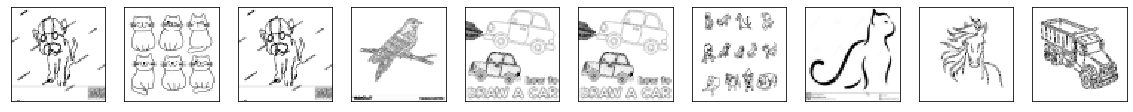

bird


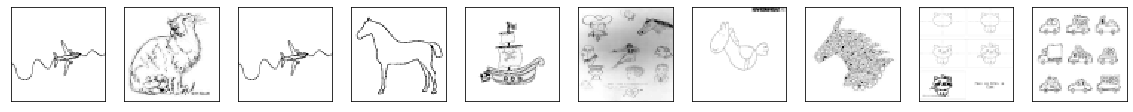

car


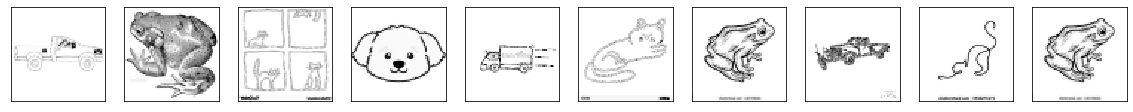

cat


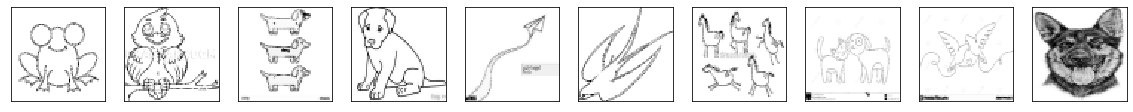

dog


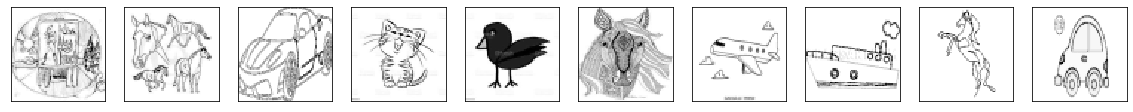

frog


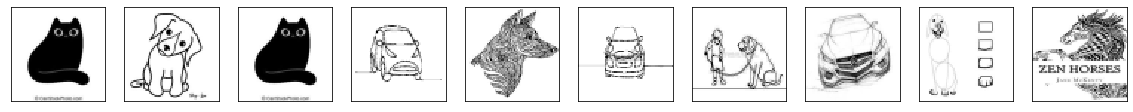

horse


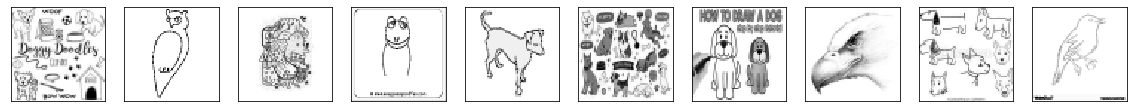

ship


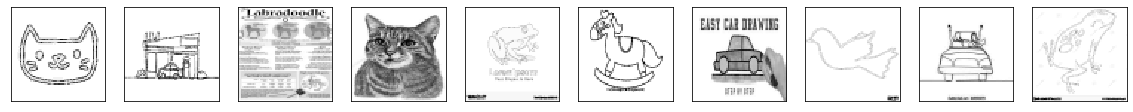

truck


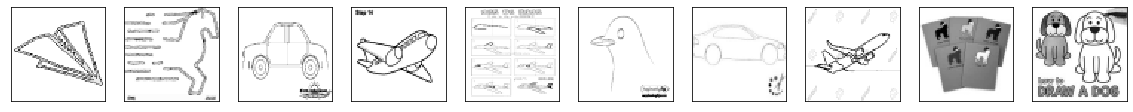

In [19]:
from error_analysis import *

cnncl = load_model(CNNCL(), "exp_data/cnncl-contrastive/cnncl-contrastive_model.pt")
analyse_errors(cnncl.dmodel, DoodleDataset(train=False), classes, n=10)

In [ ]:
from error_analysis import *

cnncl = load_model(CNNCL(), "exp_data/cnncl-contrastive/cnncl-contrastive_model.pt")
analyse_errors(cnncl.dmodel, DoodleDataset(train=False), classes, n=10)

airplane


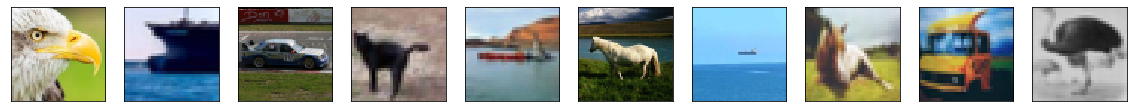

bird


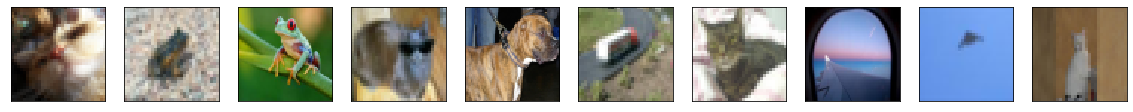

car


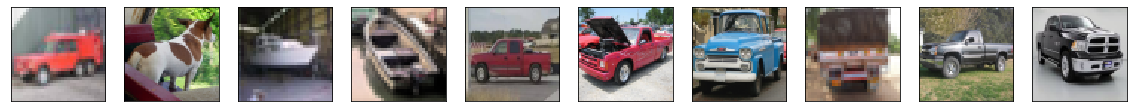

cat


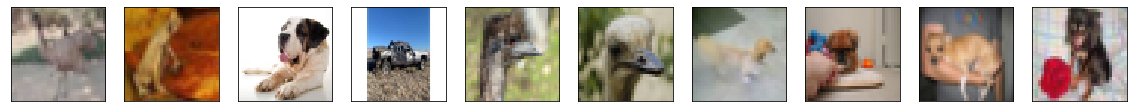

dog


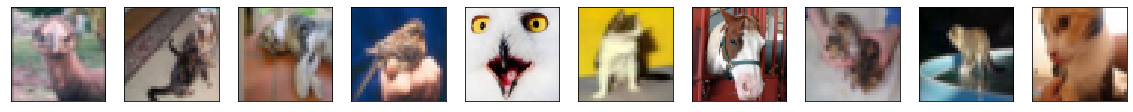

frog


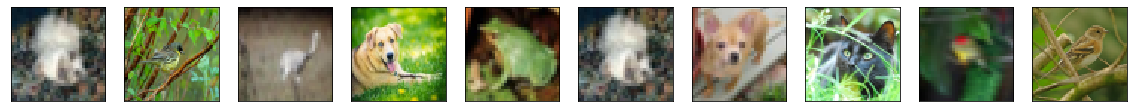

horse


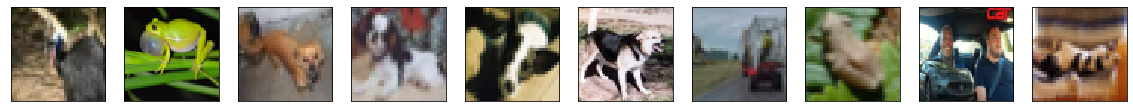

ship


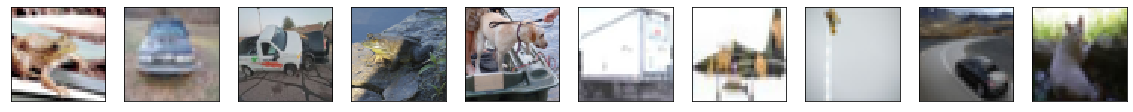

truck


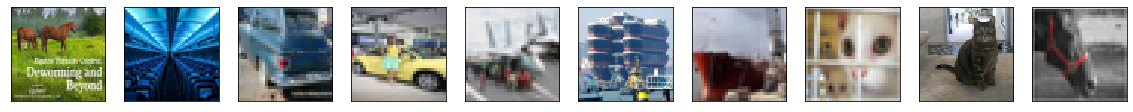

In [4]:
analyse_errors(cnncl.rmodel, RealDataset(train=False), classes, n=10)

### 7.2 t-SNE visualization

We wish to analyse how the CNN trained using contrastive learning generates better embeddings for doodles and real images respectively than the CNN trained without contrastive learning. We use the $t$-Stochastic Neighbour Embeddings (t-SNE) method to visualise the output embeddings on the validation set in 2D space.

We expect that the embeddings for CNN (V2) are not well separated/clustered, while the embeddings for CNN-CL (V3) are well-separated. This is because the contrastive loss in CNN-CL pulls doodles and real images of the same class together (positive pairs), and pushes apart those of different clases (negative pairs). The contrastive loss maximises the cosine similarity of embeddings of positive pairs and minimises that for negative pairs.

Unsurprisingly, we see in the t-SNE visualisation that the embeddings indeed meet our expectations. The clusters in t-SNE for CNN, especially for doodle embeddings, can be somewhat conflated together, but the t-SNE for CNN-CL clusters are well separated between classes.

Such better separated embeddings of CNN-CL lends itself well for our doodle-based image search application, as we use embeddings to represent query doodles and use cosine similarity to retrieve the top $k$ similar photos in the database.

Nonetheless, we believe that more can potentially be done in the contrastive methods used, especially since it seems that within each class, embeddings are not spread out, possibly due to "dimensional collapse"<sup>1</sup>, a recently surfaced issue of contrastive learning methods that require including other loss terms for consistency within classes.

One common method in contrastive learning uses data augmentations to obtain different "views" of the same image as a positive pair, and a different image as a negative pair. In the context of our project, due to time constraints and this being outside the scope of the class, we leave exploring using negative pairs between different images within the same class as future work.

---

<sup>1</sup> Jing, L., Vincent, P., LeCun, Y., & Tian, Y. (2021). Understanding dimensional collapse in contrastive self-supervised learning. arXiv preprint arXiv:2110.09348.

In [6]:
from model_analysis import *

tsne_d = Tsne(DoodleDataset(train=False))
tsne_r = Tsne(RealDataset(train=False))

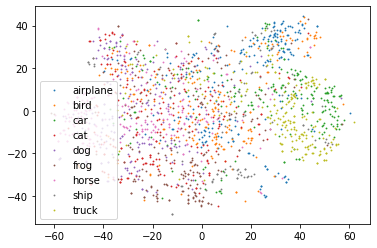

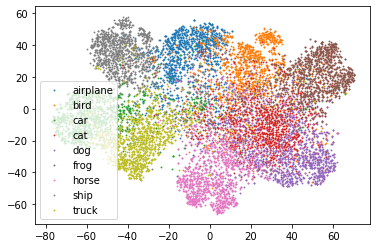

In [8]:
cnn_doodle = load_model(CNN(n_channels=1), "exp_data/cnn-doodle/cnn-doodle_model.pt")
cnn_real = load_model(CNN(n_channels=3), "exp_data/cnn-real/cnn-real_model.pt")
tsne_d.visualise(cnn_doodle)
tsne_r.visualise(cnn_real)

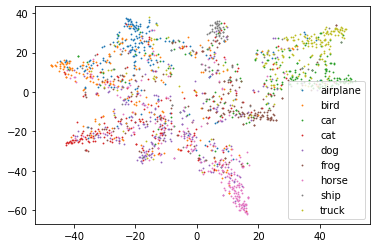

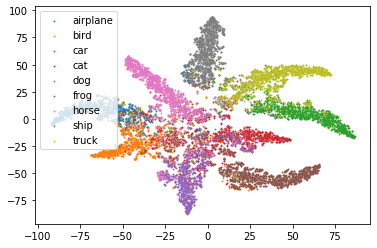

In [9]:
cnncl = load_model(CNNCL(), "exp_data/cnncl-contrastive/cnncl-contrastive_model.pt")
tsne_d.visualise(cnncl.dmodel)
tsne_r.visualise(cnncl.rmodel)

### 7.3 GradCAM - 

This project's major contributions lie in the CNNs trained above. To understand our convolutional models better, we use GradCAM (Gradient-weighted Class Activation Mapping)<sup>1</sup>, a method to visualise where the convolutional model is focusing on. It looks out for the most salient features in the image and predicts a class majorly influenced by said features.

<sup>1</sup> Selvaraju, R. R., Cogswell, M., Das, A., Vedantam, R., Parikh, D., & Batra, D. (2017). Grad-cam: Visual explanations from deep networks via gradient-based localization. In Proceedings of the IEEE international conference on computer vision (pp. 618-626).


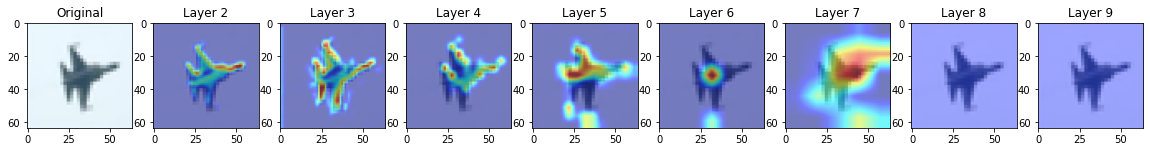

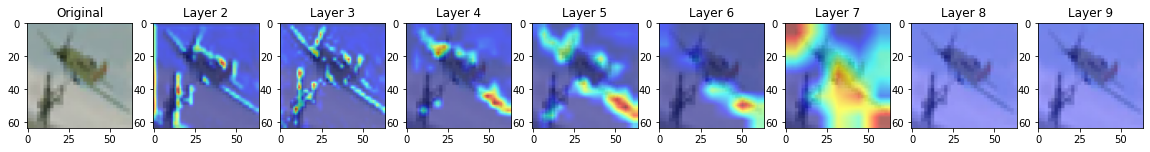

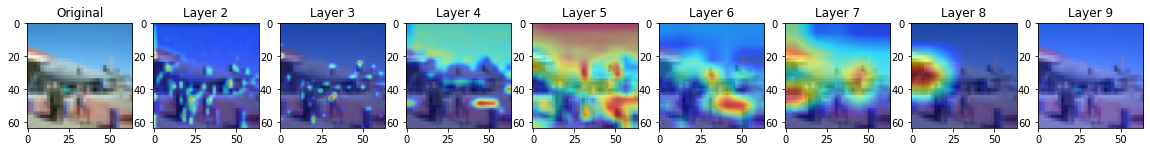

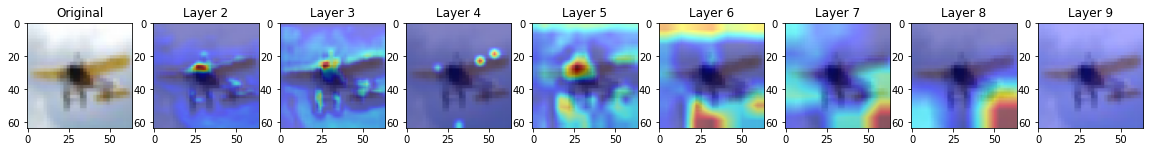

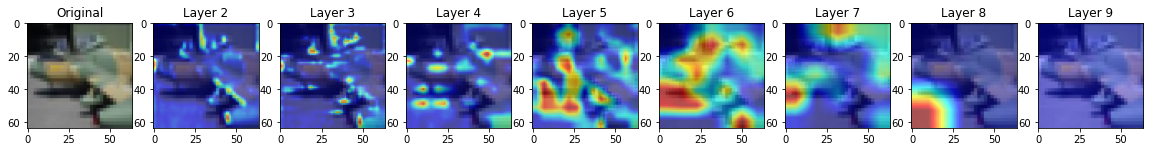

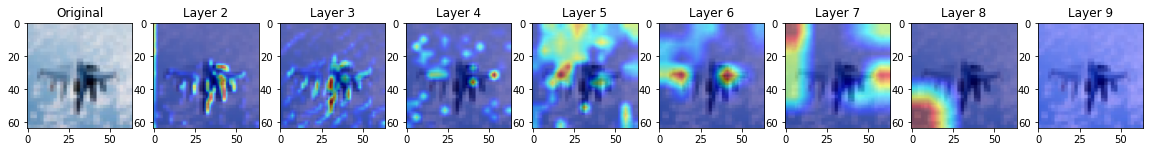

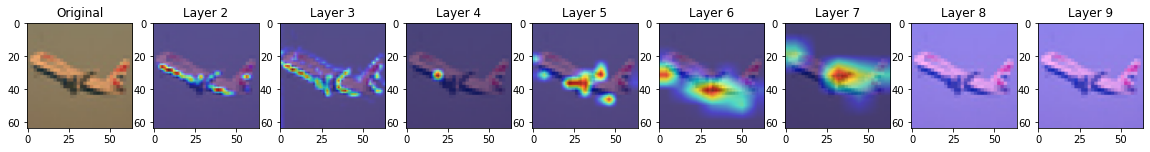

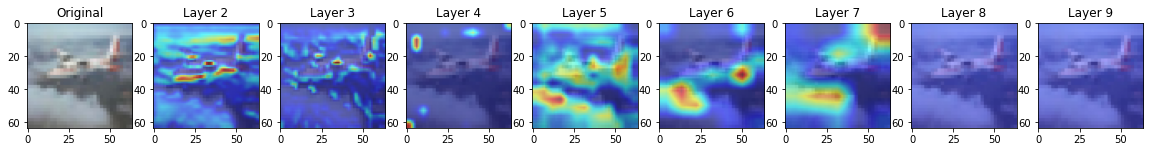

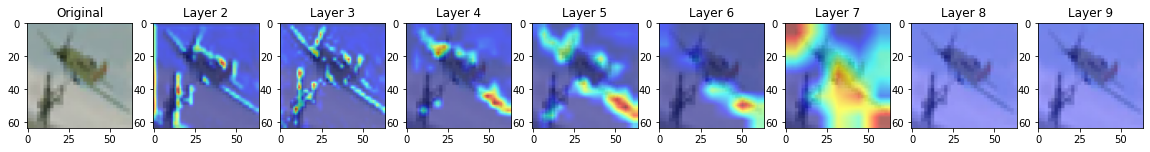

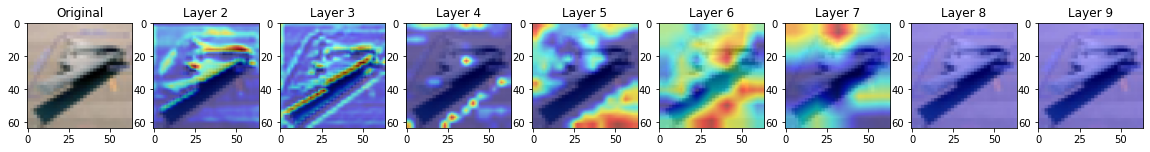

In [1]:
from model_analysis import *

realset = RealDataset(train=False)

cnncl = load_model(CNNCL(), "exp_data/cnncl-contrastive/cnncl-contrastive_model.pt")
cnncl_real = cnncl.rmodel.eval()

gradcam = GradCAMUtil(realset, bs=512)
gradcam.visualise_random_batch(cnncl_real)

### 7.4 Search Engine Accuracy Comparison

In [1]:
from model_analysis import *
from engine import *

doodle_val_set = DoodleDataset(train=False)
real_val_set = RealDataset(train=False)

In [3]:
cnn_doodle = load_model(CNN(n_channels=1), "exp_data/cnn-doodle/cnn-doodle_model.pt").eval()
cnn_real = load_model(CNN(n_channels=3), "exp_data/cnn-real/cnn-real_model.pt").eval()

engine = Engine3(real_val_set, cnn_doodle, cnn_real)
test_search_acc_top(cnn_doodle, cnn_real, engine, doodle_val_set, k=5)

0.19

In [2]:
mlp_doodle = load_model(MLP(n_input=64*64, n_linear=2), "exp_data/mlp-doodle/mlp-doodle_model.pt").eval()
mlp_real = load_model(MLP(n_input=64*64*3, n_linear=2), "exp_data/mlp-real/mlp-real_model.pt").eval()

engine = Engine3(real_val_set, mlp_doodle, mlp_real)
test_search_acc_top(mlp_doodle, mlp_real, engine, doodle_val_set, k=5)

0.23

In [4]:
cnncl = load_model(CNNCL(), "exp_data/cnncl-contrastive/cnncl-contrastive_model.pt")
cnncl_doodle = cnncl.dmodel.eval()
cnncl_real = cnncl.rmodel.eval()

engine = Engine3(real_val_set, cnn_doodle, cnncl_real)
test_search_acc_top(cnncl_doodle, cnncl_real, engine, doodle_val_set, k=5)

0.52

In [ ]:
cnn_doodle = load_model(CNN(n_channels=1), "exp_data/cnn-doodle/cnn-doodle_model.pt").eval()
cnn_real = load_model(CNN(n_channels=3), "exp_data/cnn-real/cnn-real_model.pt").eval()

engine = Engine3(real_val_set, cnn_doodle, cnn_real)
test_search_acc_top(cnn_doodle, cnn_real, engine, doodle_val_set, k=5)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d053321a-3e01-4f03-b20f-42f67dacedca' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>